# Week 3: Firm Growth Dynamics

This week's tutorial focuses on simulating firm growth, starting with the Kesten Model and then moving to simulating firm growth with a target size.

You will learn to write basic Python loops and functions. Then we introduce numpy to speed up the code and use matrix operations.


## Section 1: The Kesten Model

The Kesten Model is a stochastic model that can be used to describe the growth of firms. It is defined by the recursive equation:

$$x_{t+1} = x_{t} b_{t} + a_{t},$$

where $x_{t}$ represents the firm's size at time $t$, $b_{t}>0$ is a random variable representing firm's growth rate, and $a_{t}>0$ is a base growth rate (which we assume to be constant).

In [1]:
# import the necessary packages
import matplotlib.pyplot as plt # for plotting
import random # for random number generation (built-in, not numpy)
import numpy as np

#### Task 1: Write a function that simulates the Kesten Model

In [2]:
def kesten_process(steps):
    x_seq = [1.0]
    a = 0.1
    b = random.normalvariate(1.3,0.1)
    for i in range(1,steps):
        x_seq.append(b*x_seq[i-1]+a)
    return x_seq

#### Task 2: Simulate the Kesten Model for 1000 periods and 10_000 firms

In [3]:
n_firms = 10_000
n_steps = 1000

sequences = []
for i in range(n_firms):
    sequences.append(kesten_process(steps=n_steps))

#### Task 3: Plot some trajectories of firm growth and the distribution of firm sizes

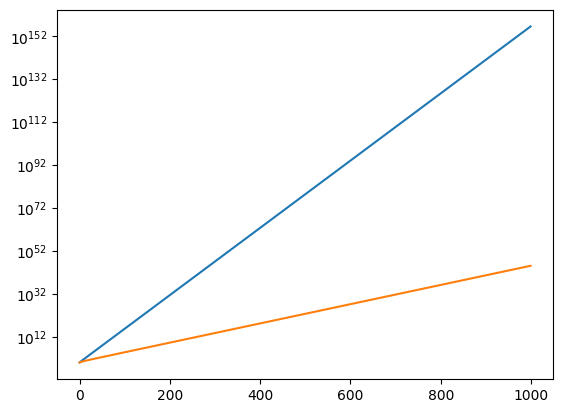

In [4]:
# lets plot the first 2 sequences
plt.plot(sequences[0])
plt.plot(sequences[1])
plt.yscale('log')
plt.show()

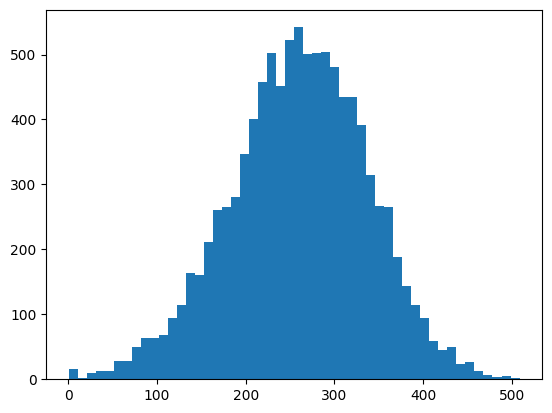

In [5]:
# plot the size distribution using log sized bins
final_sizes = [np.log(sequence[-1]) for sequence in sequences]
plt.hist(final_sizes, 50)
plt.show()

## Section 2: Numpy Vectorization

Numpy is the foundation of scientific computing in Python, enabling operations across arrays simultaneously and eliminating (mostly) the need for explicit loops.

This feature is especially useful in this exercise. Since this growht process is an example of an [Embarrassingly Parallel Task](https://en.wikipedia.org/wiki/Embarrassingly_parallel).

This is because we can simulate the growth of multiple firms at the same time, as one firm's growth does not affect another's.

To leverage numpy's vectorization, we need to rewrite the Kesten Model as matrix operations.

#### Task 1: Simulate the Kesten Model for 1000 periods and 10_000 firms using numpy and plot the distribution of firm sizes

In [6]:
n_time = 1_000
n_firms = 10_000
mu = 1.05
std = 0.05

# Matrix Definition
A = np.ones((n_firms, n_time))*0.1
B = np.abs(np.random.lognormal(0.0,0.3,(n_firms, n_time)))
x0 = np.ones((n_firms, n_time))

# YOU CODE HERE
evolution = np.ones((n_firms, n_time))
for i in range(1,n_time):
    evolution[:, i] = evolution[:, i-1]*B[:, i-1]+A[:, i-1]

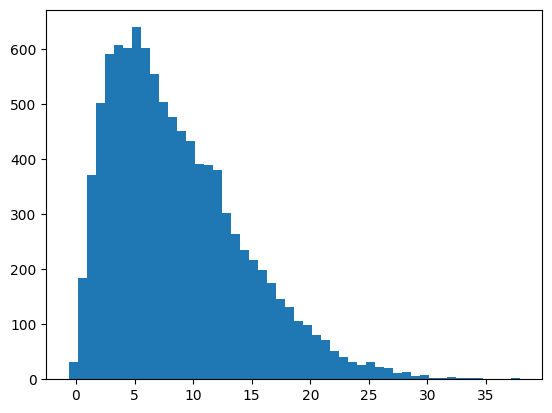

In [7]:
# plot the histogram
# YOU CODE HERE
final_sizes_vector = evolution[:, -1]
plt.hist(np.log(final_sizes_vector), 50)
plt.show()

## Section 3: Simulating Growth Towards a Target Size

This section explores a model where firms grow towards a target size, $x^*$, expanding when they are below the target and contracting when they are above it.

The size of a firm at $t+1$, $x_{t+1}$, is given by the following equation:

\begin{align*}
  x_{t+1}= x_t \cdot \epsilon_t \cdot \left\{
  \begin{array}{ll}
    k, & \text{if } x_t \leq x^* \quad \text{(Expansion)}\\
    \frac{1}{k}, & \text{if } x_t > x^* \quad \text{(Contraction)}
  \end{array} \right.
\end{align*}

The growth rate, denoted by $\epsilon_t$, is adjusted by a scaling factor $k>1$, modifying the growth rate based on the firm's current size.


In this example, $\epsilon_t$ is a growth rate sampled from an iid log-normal distribution.


#### Task 1: Simulate growth with Numpy

In [57]:
# Set the target size for firm growth
target_size = 2000

# Generate a matrix E with log-normal growth rates for each agent at each time step (mean=0, std=0.3)
E = np.random.lognormal(0, .3, (n_firms, n_time))

# Set the growth factor (k) used when a firm's size is smaller than the target size
k = 1.15

# Initialize the current size (x0) of each agent to 1
x0 = np.ones(n_firms)

# Initialize a matrix to store size of each firm at each time step
xs = np.ones((n_firms, n_time))

# Simulate the growth process over time
for t in range(1,n_steps):
    xs[:, t] = xs[:, t-1] * E[:, t-1] * np.where(xs[:, t-1] < target_size, k, 1/k)

#### Task 2: Plot the Distribution of Log-Rates

Unlike the Kesten process, the growth rates in this scenario are not iid; specifically, they are not independent. This dependency arises because the next growth rate could be either $k \epsilon_t$ or $\frac{\epsilon_t}{k}$, depending on $x_t$.

In the Kesten process (above), the distribution of growth rates was predetermined, and therefore, we did not investigate its distribution. However, in this case, the distribution of growth rates is unknown a priori.

To determine the distribution of growth rates, we define $r_t = \ln(\frac{x_{t+\tau}}{x_t})$, extracting these values from the simulation at each firm and timestep. Notice the logarithm to obtain log-growth.

Note that $\tau$ represents the time lag, which we will set to $\tau=1$.

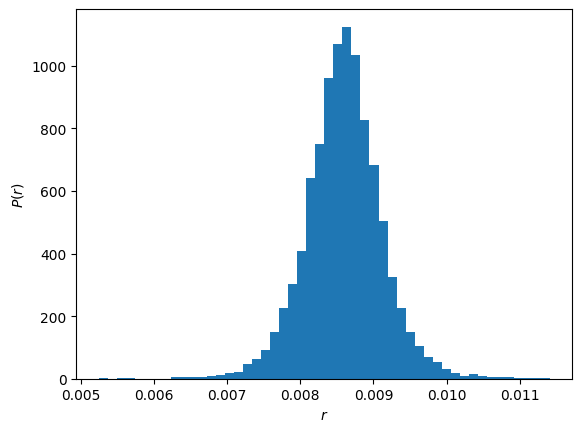

In [85]:
# Plot the size distribution at the end of the simulation
final_firm_sizes = xs[:, -1]

# plt.plot(xs[0])

rs = np.ones((n_firms, n_time))
tau = 1
for i in range(tau, n_time):
    rs[:, i] = np.log(xs[:, i]/xs[:, i-tau])

hist, bins = np.histogram(rs.flatten(), bins=np.linspace(-2,2,101), density=True)


plt.figure()
# plt.plot(bins[:-1], hist, '.', color='red')
plt.hist(rs.mean(axis=1), 50)
plt.xlabel('Log-Growth Rate')
plt.ylabel('Probability')
# plt.yscale('log')

# plot laplacian distribution from scipy
lap_var = rs.var() / (np.sqrt(2)  * np.log(k))
mu = 0

from scipy.stats import laplace, norm

# plotting code
x = np.linspace(-2, 2, 101)
# plt.plot(x, laplace.pdf(x, 0, .4), 'k--', label='Laplace', lw=1)
# plt.plot(x, norm.pdf(x, 0, .3), 'k--', label='Gaussian', lw=1)
plt.xlabel('$r$')
plt.ylabel('$P(r)$')
# plt.legend()
plt.savefig('log_growths_laplace.pdf')
plt.show()


**Questions:**

1. What distribution do the log-returns follow? 
1. How does the distribution of log-returns change as $\tau$ increases?
2. Set $k$ to a high number, e.g., 3, and observe the distribution of log-returns for different $\tau$ values. What do you observe? Why is this?

#### Task 3: Plot firm size distribution

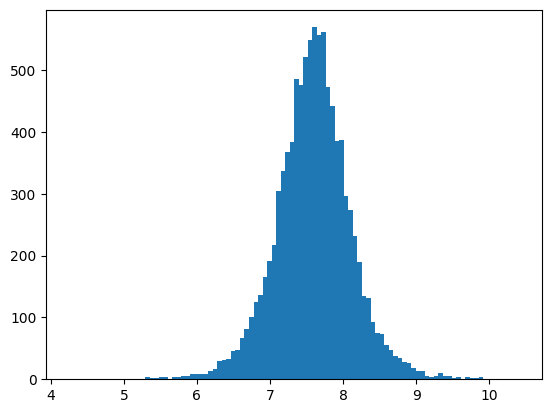

In [105]:
# plot size distribution in log-log scale
plt.hist(np.log(final_firm_sizes), 100)
plt.show()

**Questions:** Why does the firm size distribution not converge to a log-normal distribution? What assumption is violated?

#### Task 4: Explicit Sampling of Growth Rates from a Laplace Distribution

In the previous exploration, growth rates derived from an implicitly Laplacian distribution were not iid, leading to a non-log-normal firm size distribution. 


**Questions:**  If we explicitly sample growth rates from a Laplace distribution, i.e., satisfying the iid assumption, what distribution of firm sizes should we now expect?


The growth process is defined as:
$$
x_{t+1} = x_t \times \lambda_i
$$

This can be equivalently expressed as:
$$
x_{t+1} = x_0 \times \prod_{i=1}^{t} \lambda_i
$$

Or in log form:
$$
\ln(x_{t+1}) = \ln(x_0) + \sum_{i=1}^{t} \ln(\lambda_i)
$$

Here, $\ln(\lambda_i)$ is sampled from a Laplace distribution with a mean of 0.1 and a scale of 0.4. Since $x_0 = 1$, $\ln(x_0)$ is zero and omitted.

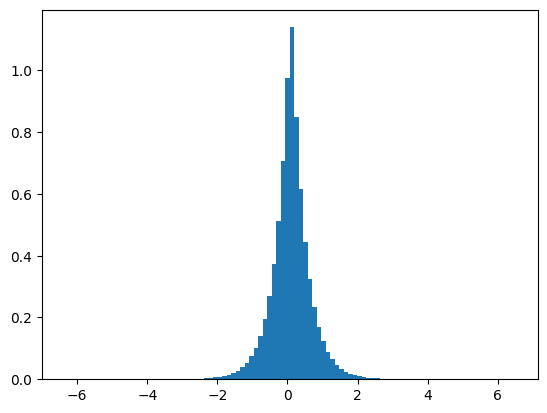

In [106]:
L = np.random.laplace(0.1, .4, (n_firms, n_time))
# show the distribution
plt.hist(L.flatten(), bins=100, density=True);

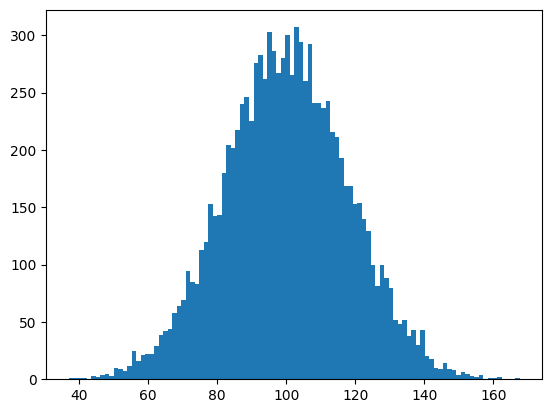

In [107]:
# show firm size distribution
plt.hist(L.sum(axis=1), 100);